## 0. Introduction
The below code includes all my modeling for my regression analysis of the strategic subject algorithm, as well as scattered commentary. For detailed analysis, see the file `report.pdf` available in this directory. Some of the cross validation steps take many hours - don't run this all at once.

In [34]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [197]:
# To study the distribution of the predictor `RAT AGE AT LATEST ARREST`,
# we need a function to convert it to a continuous variable.
def age_converter(agestring):
    if agestring=='less than 20':
        return 0.0
    else:
        return (float(agestring[0]) - 1)
    
def rmse(predicted, observed):
    return np.sqrt(np.mean((predicted - observed)**2))

In [100]:
df = pd.read_csv("Strategic_Subject_List.csv", low_memory=False)

In [198]:
predictors = df[['SSL SCORE', 'PREDICTOR RAT AGE AT LATEST ARREST',\
       'PREDICTOR RAT VICTIM SHOOTING INCIDENTS',\
       'PREDICTOR RAT VICTIM BATTERY OR ASSAULT',\
       'PREDICTOR RAT ARRESTS VIOLENT OFFENSES',\
       'PREDICTOR RAT GANG AFFILIATION', 'PREDICTOR RAT NARCOTIC ARRESTS',\
       'PREDICTOR RAT TREND IN CRIMINAL ACTIVITY', 'PREDICTOR RAT UUW ARRESTS']].dropna()
predictors['PREDICTOR RAT AGE AT LATEST ARREST'] = predictors['PREDICTOR RAT AGE AT LATEST ARREST'].apply(age_converter)

# 1. Linear Regression on SSL Scores

Below I brainstormed few options for improving linear regression performance/identifying structure in the residuals.

TODO: give confidence intervals of coefficients using bootstrapping

TODO: use `statsmodels` function `het_breuschpagan` to detect heteroscedasticity

TODO: log transform of variables

TODO: Box/cox transform

TODO: Heteroscedasticity-consistent standard errors

## 1.1 Age-only linear regression
Since age is such a strong predictor, we may as well see how well a model if it incorporates age only.

In [199]:
X, y = predictors['PREDICTOR RAT AGE AT LATEST ARREST'].values.reshape(-1,1),\
       predictors['SSL SCORE'].values.reshape(-1,1)
reg = LinearRegression()
reg.fit(X,y)
rmse(reg.predict(X), y)

19.55824685163662

## 1.2 Linear regression with normalized features
This allows us to read off feature importances as the absolute values of the fitted coefficients.

In [132]:
X_lin_scaled = StandardScaler().fit_transform(X)
model = sm.OLS(y, sm.add_constant(X_lin_scaled))
norm_results = model.fit()
print(norm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 9.430e+05
Date:                Mon, 28 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:20:01   Log-Likelihood:            -1.5869e+06
No. Observations:              398582   AIC:                         3.174e+06
Df Residuals:                  398573   BIC:                         3.174e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        279.8999      0.021   1.36e+04      0.0

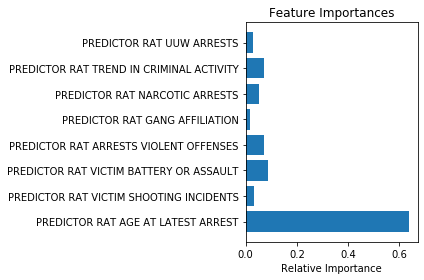

In [133]:
plt.barh(range(8), np.abs(norm_results.params[1:]) * 1./np.sum(np.abs(norm_results.params[1:])))
plt.title("Feature Importances")
plt.xlabel("Relative Importance")
plt.yticks(ticks=range(8), labels=predictors.drop('SSL SCORE', axis=1).columns)
plt.tight_layout()
plt.show()

## 1.3 OLS linear regression
Features are not normalized this time. Below we have the RMSE.

In [37]:
reg = LinearRegression()
reg.fit(X,y)
rmse_ols = np.sqrt(np.mean((reg.predict(X) - y)**2))
print("RMSE OLS: " + str(rmse_ols))

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

RMSE OLS: 12.965995748176073
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 9.430e+05
Date:                Sat, 26 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:42:17   Log-Likelihood:            -1.5869e+06
No. Observations:              398582   AIC:                         3.174e+06
Df Residuals:                  398573   BIC:                         3.174e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        344.1459  

## 1.4 Principal component analysis
For commentary, see report.

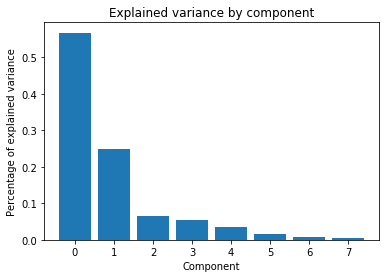

In [90]:
from sklearn.decomposition import PCA
transformer = PCA(n_components=8)
X_pca = transformer.fit_transform(X)

plt.bar(range(8), transformer.explained_variance_ratio_)
plt.title("Explained variance by component")
plt.ylabel("Percentage of explained variance")
plt.xlabel("Component")
plt.show()

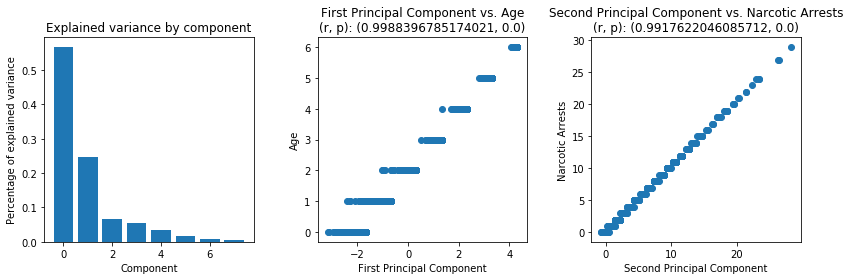

In [122]:
pca_r1 = pearsonr(X_pca[:,0], X[:,0])
pca_r2 = pearsonr(X_pca[:,1], X[:,5])

plt.subplots(figsize=(12,4))
plt.subplot(1,3,1)
plt.bar(range(8), transformer.explained_variance_ratio_)
plt.title("Explained variance by component")
plt.ylabel("Percentage of explained variance")
plt.xlabel("Component")

plt.subplot(1,3,2)
plt.scatter(X_pca[:,0], X[:,0])
plt.xlabel("First Principal Component")
plt.ylabel("Age")
plt.title("First Principal Component vs. Age\n(r, p): " + str(pca_r1))

plt.subplot(1,3,3)
plt.scatter(X_pca[:,1], X[:,5])
plt.xlabel("Second Principal Component")
plt.ylabel("Narcotic Arrests")
plt.title("Second Principal Component vs. Narcotic Arrests\n(r, p): " + str(pca_r2))
plt.tight_layout()
plt.show()

## 1.5 Regularized linear regression
The below is an involved attempt at using PCA, in combination with polynomial features, in combination with regularization, to improve RMSE. It didn't work - regularization is unhelpful even with cross-validated penalization paramater $\alpha$, so we don't include it in the report.

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=80)
X_pca = pca.fit_transform(X_poly)

In [11]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# scaling before regularized regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1,\
                                                    test_size=.2)

rdg_param_grid= {'alpha': np.linspace(10, 10000, 100)}
lso_param_grid= {'alpha': np.linspace(.001, 10, 100)}
elt_param_grid= {'alpha': np.linspace(.0001, .01, 100)}

In [19]:
rdg = GridSearchCV(Ridge(), rdg_param_grid, cv=5)
rdg.fit(X_train,y_train)
best_rdg = Ridge(alpha = rdg.best_params_['alpha'])
best_rdg.fit(X_train,y_train)
rmse_rdg = np.sqrt(np.mean((best_rdg.predict(X_test) - y_test)**2))

In [22]:
lso = GridSearchCV(Lasso(), lso_param_grid, cv=5)
lso.fit(X_train,y_train)
best_lso = Lasso(alpha = lso.best_params_['alpha'])
best_lso.fit(X_train,y_train)
rmse_lso = np.sqrt(np.mean((best_lso.predict(X_test) - y_test)**2))

In [ ]:
elt = GridSearchCV(ElasticNet(), elt_param_grid, cv=5)
elt.fit(X_train,y_train)
best_elt = ElasticNet(alpha = elt.best_params_['alpha'])
best_elt.fit(X_train,y_train)
rmse_elt = np.sqrt(np.mean((best_elt.predict(X_test) - y_test)**2))

(rdg.best_params_, rmse_rdg), (lso.best_params_, rmse_lso), (elt.best_params_, rmse_elt)

## 1.6 Linear Regression with polynomial features
With polynomial features, we get an RMSE of 12.44. A little better, however there is a massive increase in parameters.

Nevertheless, the F-statistic and the AIC suggest that the model is improved.

In [7]:
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(X)

X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, random_state=1,\
                                                    test_size=.2)

reg_poly = LinearRegression()
reg_poly.fit(X_poly_train,y_train)
rmse_poly = np.sqrt(np.mean((reg_poly.predict(X_poly_test) - y_test)**2))
print("RMSE: " + str(rmse_poly))

RMSE: 12.482324126717515


In [ ]:
RSS_full = np.sum((y - reg_poly.predict(X_poly))**2)
RSS_reduced = np.sum((y - reg.predict(X))**2)
DF_full = len(y) - len(X_poly[0])
DF_reduced = len(y) - 8

F = (RSS_reduced - RSS_full)/(DF_reduced - DF_full)/(RSS_full/DF_full)
F

from scipy.stats import f
1 - f.cdf(F,DF_reduced,DF_full)

In [10]:
# A more verbose summary of the results of our model
model = sm.OLS(y, sm.add_constant(X_poly))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 5.312e+04
Date:                Fri, 25 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:18:02   Log-Likelihood:            -1.5702e+06
No. Observations:              398582   AIC:                         3.141e+06
Df Residuals:                  398426   BIC:                         3.142e+06
Df Model:                         155                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        338.8418      0.059   5744.690      0.0

Residuals of the polynomial fit are evenly distributed, but not normally distributed.

NormaltestResult(statistic=29497.742656525923, pvalue=0.0)

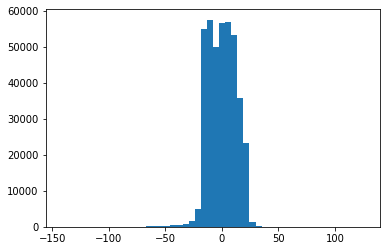

In [11]:
resids = reg_poly.predict(X_poly) - y
plt.hist(resids, bins=50)
from scipy.stats import normaltest
normaltest(resids)

X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, random_state=10, test_size=.2)
reg_poly.fit(X_poly_train, y_poly_train)
rmse_poly = rmse(reg_poly.predict(X_poly_test), y_poly_test)
rmse_poly

# 1.7 Random forests on SSL scores

### out of the box
Use 100 estimators, every feature

In [168]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=.2)

reg = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True)
reg.fit(X_train,y_train)
rmse(reg.predict(X_test), y_test)

12.584065823877262

Use 100 estimators, $sqrt(8) \sim 3$ features

These are the cross-validated random forest features for SSL Score regression.

({'n_estimators': 400,
  'min_samples_split': 20,
  'min_samples_leaf': 1,
  'max_features': 3},
 12.469405616996754)

In [170]:
# takes a while
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'max_features':[3], 'min_samples_split':[10,15,20,25,30,50],\
              'n_estimators':[400],'min_samples_leaf': [1]}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,\
                               param_distributions = param_grid,\
                               n_iter = 100, cv = 5, verbose=2,\
                               random_state=42, n_jobs = -1)
              
rf_random.fit(X_train,y_train)
rf_random.best_params_, rmse(rf_random.predict(X_test), y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 29.7min finished


({'n_estimators': 400,
  'min_samples_split': 20,
  'min_samples_leaf': 1,
  'max_features': 3},
 12.469405616996754)

## Fit a regressor with the cross-validated parameters

In [ ]:
rf = RandomForestRegressor(n_estimators=400, max_features=3, min_samples_split=20, min_samples_leaf=1,\
                            oob_score=True)
rf.fit(X_train,y_train)
rmse(reg.predict(X_test), y_test)

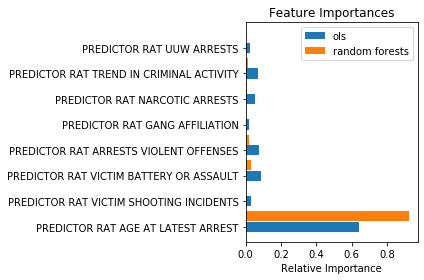

In [157]:
plt.barh(np.arange(8),np.abs(norm_results.params[1:]) * 1./np.sum(np.abs(norm_results.params[1:])),\
         height=.4, label='ols')
plt.barh(np.arange(8)+.41, rf.feature_importances_,\
         height=.4, label='random forests')
plt.title("Feature Importances")
plt.xlabel("Relative Importance")
plt.yticks(ticks=range(8), labels=predictors.drop('SSL SCORE', axis=1).columns)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 1.8 Using `xgboost` to predict SSL scores

In [18]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=2, test_size=.2)

In [19]:
num_round = 100
param = {'max_depth': 6, 'eta': .2,\
         'objective': 'reg:squarederror',\
        'booster':'dart' }
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist,\
                early_stopping_rounds=50)

[0]	eval-rmse:228.576	train-rmse:228.376
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 50 rounds.
[1]	eval-rmse:183.074	train-rmse:182.922
[2]	eval-rmse:146.711	train-rmse:146.599
[3]	eval-rmse:117.672	train-rmse:117.57
[4]	eval-rmse:94.5083	train-rmse:94.4108
[5]	eval-rmse:76.0499	train-rmse:75.962
[6]	eval-rmse:61.3634	train-rmse:61.2785
[7]	eval-rmse:49.7251	train-rmse:49.6477
[8]	eval-rmse:40.546	train-rmse:40.4759
[9]	eval-rmse:33.3513	train-rmse:33.2861
[10]	eval-rmse:27.7737	train-rmse:27.7131
[11]	eval-rmse:23.4983	train-rmse:23.4386
[12]	eval-rmse:20.2872	train-rmse:20.2267
[13]	eval-rmse:17.9153	train-rmse:17.8515
[14]	eval-rmse:16.1981	train-rmse:16.1342
[15]	eval-rmse:14.9926	train-rmse:14.9274
[16]	eval-rmse:14.157	train-rmse:14.0878
[17]	eval-rmse:13.5883	train-rmse:13.5151
[18]	eval-rmse:13.2007	train-rmse:13.1274
[19]	eval-rmse:12.9434	train-rmse:12.868
[20]	eval-rmse:12.7703	train-r

In [20]:
bst.feature_names

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']

# 2. Predicting `TREND`

Below are functions we'll need to account for NaN values in the unused fields of the SSL. For details, see the report.

In [201]:
def triangular_number(n):
    return n * (n + 1) / 2

def slopecalc(year, sub=0.):
    if year==sub:
        return 0.
    elif year<2012:
        base_year = year
        n = int(2016 - base_year + 1)
    else:
        base_year = 2012
        n = 5
    i = int(year - base_year)
    X = np.asarray(list(range(n))).reshape(-1,1)
    Y = np.zeros_like(X)
    Y[i] = 1
    
    return ((Y[i]*X[i] + -1./n * (triangular_number(n - 1))) /(np.var(X)*n))[0]
    

In [213]:
trend_predictors = df[['PREDICTOR RAT TREND IN CRIMINAL ACTIVITY',\
                       'SSL SCORE', 'PREDICTOR RAT AGE AT LATEST ARREST',\
                       'PREDICTOR RAT VICTIM SHOOTING INCIDENTS',\
                       'PREDICTOR RAT VICTIM BATTERY OR ASSAULT',\
                       'PREDICTOR RAT ARRESTS VIOLENT OFFENSES',\
                       'PREDICTOR RAT GANG AFFILIATION',\
                       'PREDICTOR RAT NARCOTIC ARRESTS',\
                       'PREDICTOR RAT UUW ARRESTS','LATEST DATE',\
                       'WEAPONS ARR CNT',\
                       'LATEST WEAPON ARR DATE',\
                       'NARCOTICS ARR CNT',\
                       'LATEST NARCOTIC ARR DATE',\
                       'DOMESTIC ARR CNT',\
                       'LATEST DOMESTIC ARR DATE',\
                       'SSL LAST PTV DATE']].dropna(subset=['PREDICTOR RAT AGE AT LATEST ARREST'])

trend_predictors['PREDICTOR RAT AGE AT LATEST ARREST'] =\
    trend_predictors['PREDICTOR RAT AGE AT LATEST ARREST'].apply(age_converter)

sub=0.
trend_predictors = trend_predictors.fillna(value = {'LATEST DATE':sub,\
                                  'WEAPONS ARR CNT': 0, 'LATEST WEAPON ARR DATE': sub,\
                                  'NARCOTICS ARR CNT': 0, 'LATEST NARCOTIC ARR DATE':sub,\
                                  'DOMESTIC ARR CNT': 0, 'LATEST DOMESTIC ARR DATE': sub,\
                                  'SSL LAST PTV DATE': sub})
trend_predictors = trend_predictors.dropna()

X = trend_predictors.drop('PREDICTOR RAT TREND IN CRIMINAL ACTIVITY', axis=1).values

In [214]:
slope_cols = ['LATEST DATE', 'LATEST WEAPON ARR DATE',\
              'LATEST NARCOTIC ARR DATE', 'LATEST DOMESTIC ARR DATE',\
              'SSL LAST PTV DATE']

for column in list(slope_cols):
    trend_predictors[column] = trend_predictors[column].apply(slopecalc)

X_slope = trend_predictors.drop('PREDICTOR RAT TREND IN CRIMINAL ACTIVITY', axis=1).values
Y = trend_predictors['PREDICTOR RAT TREND IN CRIMINAL ACTIVITY'].values

## 2.1 Linear regression on `TREND` without slope calculation

In [204]:
linreg = LinearRegression()
linreg.fit(X, Y)

rmse(linreg.predict(X), Y)

0.3278621593954896

## 2.2 Linear regression on `TREND` with slope calculation

In [205]:
linreg.fit(X_slope, Y)
rmse(linreg.predict(X_slope), Y)

0.3135370018714263

## 2.3 Linear regression with polynomial features, no calculation

In [206]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
X_poly.shape

reg = LinearRegression()
reg.fit(X_poly, Y)
rmse(reg.predict(X_poly), Y)

0.2894635416765352

## 2.4 Linear regression with polynomial features, with calculation

In [207]:
X_slope_poly = poly.fit_transform(X_slope)
X_slope_poly.shape

reg = LinearRegression()
reg.fit(X_slope_poly, Y)
rmse(reg.predict(X_slope_poly), Y)

0.2843468520442556

### Some comments on `TREND`
An upward spike in criminal activity (the highest 100 of observed `TREND` values) almost always is associated with a `LATEST DATE` of 2016. The low end `TREND` has a mean `LATEST DATE` of 2014.76. In contrast, the list as a whole has a mean `LATEST DATE` of 2014.2. One possible explanation: a more active criminal who has not committed a crime recently ought to have a lower trend than someone who has simply not committed a crime recently.

In [25]:
np.mean(trend_predictors['LATEST DATE']),\
    np.mean(trend_predictors.iloc[y.argsort()[:100][::-1]]\
    ['LATEST DATE'])

(2014.2014516460854, 2014.76)

Entry 350020 has `TREND` of $1.2$, but is a man over 60 with no arrest record. This puts him above the 99th percentile for this variable, which indicates we might be missing data necessary for our model of `TREND`.

In [212]:
df.iloc[350020], np.percentile(trends, [1, 99])

SSL SCORE                                                                     175
PREDICTOR RAT AGE AT LATEST ARREST                                          50-60
PREDICTOR RAT VICTIM SHOOTING INCIDENTS                                         0
PREDICTOR RAT VICTIM BATTERY OR ASSAULT                                         0
PREDICTOR RAT ARRESTS VIOLENT OFFENSES                                          0
PREDICTOR RAT GANG AFFILIATION                                                  1
PREDICTOR RAT NARCOTIC ARRESTS                                                  0
PREDICTOR RAT TREND IN CRIMINAL ACTIVITY                                      1.2
PREDICTOR RAT UUW ARRESTS                                                       0
SEX CODE CD                                                                     M
RACE CODE CD                                                                  BLK
WEAPON I                                                                        N
DRUG I          

## 2.5 Cross validated random forests (no slope calculation)
These are cross-validated hyperparameters. CV code takes hours, esp. with 400 estimators which is admittedly overkill. These hyperparamters were only computed for the dataset without the slope calculation, which may explain why currently the random forests model without the slope calculation outperforms that with the slope calculation.

 ({'n_estimators': 400,
  'min_samples_split': 20,
  'min_samples_leaf': 4,
  'max_features': None},
 0.2847586591235823)
 
 The below code will run RandomizedSearchCV to recompute these.

In [ ]:
# Perform RandomizedSearchCV (takes a few hours)
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=2, test_size=.2)

param_grid = {'max_features':[4,None], 'min_samples_split':[10,15,20,50],\
              'n_estimators':[400],'min_samples_leaf': [4,6,8,10,20]}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,\
                               param_distributions = param_grid,\
                               n_iter = 100, cv = 5, verbose=2,\
                               random_state=42, n_jobs = -1)
              
rf_random.fit(X_train,y_train)
rf_random.best_params_, rmse(rf_random.predict(X_test), y_test)

## 2.5 Cross validated random forests (with slope calculation)

Same as above, using input with the slope calculation.

 ({'n_estimators': 400,
  'min_samples_split': 20,
  'min_samples_leaf': 4,
  'max_features': None},
 0.2847586591235823)

In [ ]:
# Perform RandomizedSearchCV (takes a few hours)
X_train, X_test, y_train, y_test = train_test_split(X_slope, Y, random_state=2, test_size=.2)

param_grid = {'max_features':[4,None], 'min_samples_split':[5,10,15,20,50],\
              'n_estimators':[400],'min_samples_leaf': [4,6,8,10,20]}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,\
                               param_distributions = param_grid,\
                               n_iter = 100, cv = 5, verbose=2,\
                               random_state=42, n_jobs = -1)
              
rf_random.fit(X_train,y_train)
rf_random.best_params_, rmse(rf_random.predict(X_test), y_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


## 2.6 XGBoost on Trend

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=3, test_size=.2)
num_round = 200
param = {'max_depth': 4, 'eta': .5,\
         'objective': 'reg:squarederror',\
        'booster':'dart'}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist,\
                early_stopping_rounds=10)

[0]	eval-rmse:0.443311	train-rmse:0.443415
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:0.358026	train-rmse:0.357277
[2]	eval-rmse:0.330449	train-rmse:0.329609
[3]	eval-rmse:0.320973	train-rmse:0.319771
[4]	eval-rmse:0.316189	train-rmse:0.314974
[5]	eval-rmse:0.313485	train-rmse:0.311607
[6]	eval-rmse:0.3123	train-rmse:0.310065
[7]	eval-rmse:0.310827	train-rmse:0.30855
[8]	eval-rmse:0.308814	train-rmse:0.306368
[9]	eval-rmse:0.306846	train-rmse:0.304017
[10]	eval-rmse:0.3046	train-rmse:0.301617
[11]	eval-rmse:0.303115	train-rmse:0.300165
[12]	eval-rmse:0.302197	train-rmse:0.299006
[13]	eval-rmse:0.300934	train-rmse:0.2977
[14]	eval-rmse:0.299081	train-rmse:0.29544
[15]	eval-rmse:0.298006	train-rmse:0.294457
[16]	eval-rmse:0.297738	train-rmse:0.293638
[17]	eval-rmse:0.297124	train-rmse:0.293058
[18]	eval-rmse:0.296946	train-rmse:0.292421
[19]	eval-rmse:0.295885	train-rmse:0.

[183]	eval-rmse:0.284799	train-rmse:0.263146
[184]	eval-rmse:0.284927	train-rmse:0.263096
[185]	eval-rmse:0.284769	train-rmse:0.262989
[186]	eval-rmse:0.28469	train-rmse:0.262917
[187]	eval-rmse:0.284687	train-rmse:0.262889
[188]	eval-rmse:0.284793	train-rmse:0.262843
[189]	eval-rmse:0.284784	train-rmse:0.262779
[190]	eval-rmse:0.284864	train-rmse:0.262713
[191]	eval-rmse:0.284854	train-rmse:0.262655
[192]	eval-rmse:0.284846	train-rmse:0.262623
[193]	eval-rmse:0.284833	train-rmse:0.262547
[194]	eval-rmse:0.284795	train-rmse:0.262486
[195]	eval-rmse:0.284741	train-rmse:0.262436
[196]	eval-rmse:0.284711	train-rmse:0.262364
[197]	eval-rmse:0.28466	train-rmse:0.262244
[198]	eval-rmse:0.284588	train-rmse:0.26217
[199]	eval-rmse:0.284569	train-rmse:0.262151


## 2.7 Random forests without slope calculation


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=2, test_size=.2)

rf = RandomForestRegressor(n_estimators=400, min_samples_split=20, min_samples_leaf=4, max_features=None)
rf.fit(X_train, y_train)
rmse(rf.predict(X_test), y_test)

## 2.8 Random forests with slope calculation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_slope, Y, random_state=2, test_size=.2)

rf.fit(X_train, y_train)
rmse(rf.predict(X_test), y_test)

## 2.9 Random model
How well do we do if we just guess?

In [211]:
rmse(np.random.choice(Y, size=len(Y)), Y)

0.5727358496051074